In [1]:
import os                        # To work with operation system commands
import cv2                       # To process images
import random                    # to generate random choices
import warnings                  # To avoid python warnings
import numpy as np               # To work with arrays
import pandas as pd              # To work with DataFrames
import seaborn as sns            # To visualizations
from tqdm import tqdm            # To represent progress bars
from ultralytics import YOLO     # To Create Yolo model
from termcolor import colored    # To colorfull outputs
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('ggplot')  


In [3]:
# ignore python warnings
warnings.filterwarnings('ignore')

In [4]:
working_dir = r'E:\Machine Learning Project\Object detection with yolo'

In [5]:
plate_base = r'E:\Machine Learning Project\Object detection with yolo\data\cars'

# Path of yaml file
plate_yaml_path = os.path.join(plate_base, 'data.yaml')

# Path of Train directory
plate_train_dir = os.path.join(plate_base, 'train')
plate_train_images = os.path.join(plate_train_dir, 'images')
plate_train_labels = os.path.join(plate_train_dir, 'labels')

# Path of Validation directory
plate_valid_dir = os.path.join(plate_base, 'valid')
plate_valid_images = os.path.join(plate_valid_dir, 'images')
plate_valid_labels = os.path.join(plate_valid_images, 'labels')

# Path of Test directory
plate_test_dir = os.path.join(plate_base, 'test')
plate_test_images = os.path.join(plate_test_dir, 'images')
plate_test_labels = os.path.join(plate_test_dir, 'labels')


In [6]:
import os
from termcolor import colored


def count_images_in_directory(directory, file_extensions=('.jpg', '.png')):
    return len([f for f in os.listdir(directory) if f.endswith(file_extensions)])

print(colored(f' Number of Train Images : {count_images_in_directory(plate_train_images)} ', 'blue', attrs=['bold']))
print(colored(f' Number of Validation Images : {count_images_in_directory(plate_valid_images)}', 'blue', attrs=['bold']))
print(colored(f' Number of Test Images : {count_images_in_directory(plate_test_images)} ', 'blue', attrs=['bold']))
print('_'*40)
print(colored(f' Number of All Images : {count_images_in_directory(plate_train_images) + count_images_in_directory(plate_valid_images) + count_images_in_directory(plate_test_images)} ', 'green', attrs=['bold']))


 Number of Train Images : 1287 
 Number of Validation Images : 63
 Number of Test Images : 31 
________________________________________
 Number of All Images : 1381 


In [7]:
import cv2
import os
from tqdm import tqdm
from termcolor import colored

def Image_Size(train_images):
    '''
    Read images and save image-sizes in a set
    '''
    img_sizes = set()
    
    # Loop over train images and read them
    for img_name in tqdm(os.listdir(train_images)):
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:  # Check if image was loaded correctly
            h, w, c = img.shape
            img_sizes.add((h, w))
        else:
            print(colored(f"Warning: Image {img_name} could not be loaded.", 'yellow'))
    
    return img_sizes

img_sizes = Image_Size(plate_train_images)

if len(img_sizes) == 1:
    print(colored(f'\n All the images have size of {img_sizes} ', 'green', attrs=['bold']))
else:
    print(colored(f'\n There are {len(img_sizes)} different image sizes! ', 'red', attrs=['bold']))
    print(f'Different sizes: {img_sizes}')  # Display the different image sizes


100%|██████████| 1287/1287 [00:03<00:00, 348.57it/s]


 All the images have size of {(640, 640)} 


In [8]:
import cv2
import os
from tqdm import tqdm
from termcolor import colored

def resize_images(train_images, target_size=(640, 640)):
    '''
    Resize images in the directory to the target size (default: 640x640)
    and overwrite the original images
    '''
    for img_name in tqdm(os.listdir(train_images)):
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:  # Check if image was loaded correctly
            # Resize image to the target size
            resized_img = cv2.resize(img, target_size)
            # Save the resized image, overwriting the original image
            cv2.imwrite(img_path, resized_img)
        else:
            print(colored(f"Warning: Image {img_name} could not be loaded.", 'yellow'))

# Resize all images in the train set to 640x640 and overwrite the originals
resize_images(plate_train_images)
print(colored(f'\n All images have been resized to 640x640 and saved in place!', 'green', attrs=['bold']))


100%|██████████| 1287/1287 [00:10<00:00, 121.47it/s]


 All images have been resized to 640x640 and saved in place!


In [9]:
# After resizing, check the image sizes again
img_sizes = Image_Size(plate_train_images)

# Get height and width of the resized images
H, W = list(img_sizes)[0]
print(colored(f'Height : {H}\nWidth : {W}', 'black', 'on_white', attrs=['bold']))


100%|██████████| 1287/1287 [00:11<00:00, 110.81it/s]

Height : 640
Width : 640


In [11]:
import os
import numpy as np

def remove_duplicates(images_folder, labels_folder):
    images = os.listdir(images_folder)
    unique_images = set()
    duplicate_images = []

    # Check for duplicate images
    for img_name in images:
        if img_name in unique_images:
            duplicate_images.append(img_name)
        else:
            unique_images.add(img_name)

    # Remove duplicate images and their label files
    for duplicate in duplicate_images:
        img_path = os.path.join(images_folder, duplicate)
        label_path = os.path.join(labels_folder, JPG_Name_To_TXT(duplicate))
        
        # Delete the image and label file
        if os.path.exists(img_path):
            os.remove(img_path)
        if os.path.exists(label_path):
            os.remove(label_path)

    print(f"Removed {len(duplicate_images)} duplicate images and labels.")

def JPG_Name_To_TXT(img_name):
    '''
    Based on image name, find text file in label folder.
    '''
    # Seperate prefix and suffix of image name, ensuring it handles both jpg and png extensions
    name = img_name.rsplit('.', 1)[0]  # Handle name regardless of file extension
    txt_name = name + '.txt'
    return txt_name

def TXT_To_BBOX(lbl_path):
    '''
    Read txt files and extract points of bounding-boxes.
    '''
    pts = []
    
    # Read text file and split it by white-space
    if not os.path.exists(lbl_path):
        print(f"Warning: Label file {lbl_path} does not exist!")
        return np.array([])  # Return empty array if label file does not exist

    with open(lbl_path, 'r') as bbox_file:
        bbox = bbox_file.read().split()

    # If the bbox file is not empty, extract points
    if len(bbox) >= 8:
        # Determine points of bounding box edges
        p1 = [int(float(bbox[1])*H), int(float(bbox[2])*W)]
        p2 = [int(float(bbox[3])*H), int(float(bbox[4])*W)]
        p3 = [int(float(bbox[5])*H), int(float(bbox[6])*W)]
        p4 = [int(float(bbox[7])*H), int(float(bbox[8])*W)]

        # Convert points to array and reshape it
        pts = np.array([p1, p2, p3, p4], np.int32)
        pts = pts.reshape((-1, 1, 2))
    else:
        print(f"Warning: Invalid bbox data in {lbl_path}")

    return pts

# Example usage
remove_duplicates(plate_train_images, plate_train_labels)


Removed 0 duplicate images and labels.


In [12]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [13]:
import gc

gc.collect()


20

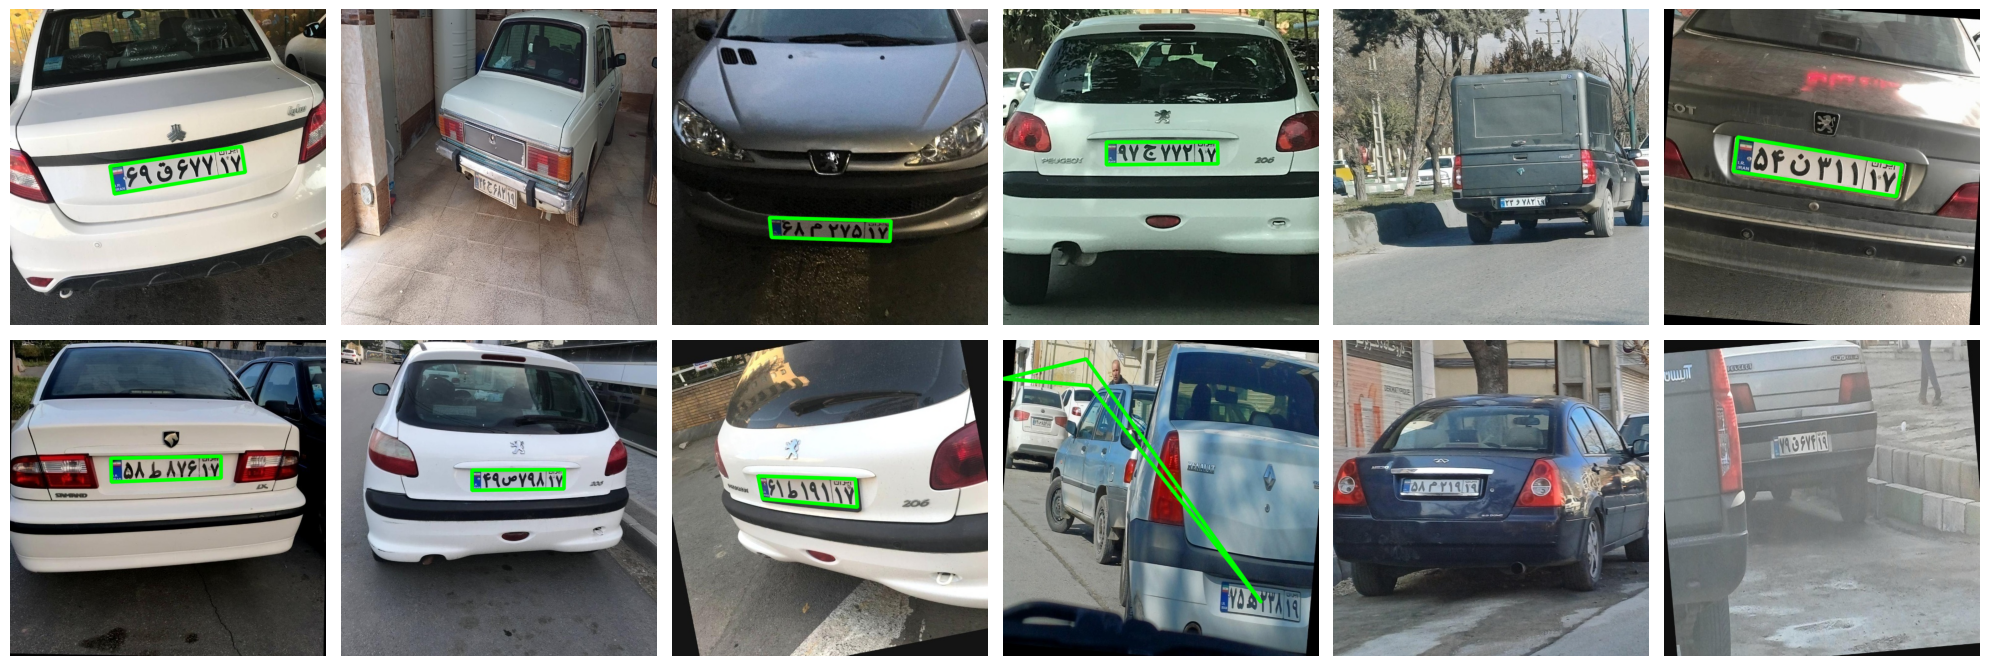

In [14]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from termcolor import colored

def Plot_Random_Images():
    '''
    Read and randomly choose some images and plot them with their bboxes in train folder.
    '''
    train_images = os.listdir(plate_train_images)
    k = min(12, len(train_images))  # Ensure we do not try to select more images than available
    random_images = random.sample(train_images, k=k)  # Avoid repetition

    plt.figure(figsize=(20, 7))
    i = 1
    for img_name in random_images:
        plt.subplot(2, 6, i)
        
        # Image
        img_path = os.path.join(plate_train_images, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            print(colored(f"Warning: Image {img_name} could not be loaded!", 'red'))
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        
        # BBox
        txt_name = JPG_Name_To_TXT(img_name)
        lbl_path = os.path.join(plate_train_labels, txt_name)
        
        if not os.path.exists(lbl_path):
            print(colored(f"Warning: Label {txt_name} not found!", 'yellow'))
            continue
        
        try:
            pts = TXT_To_BBOX(lbl_path)
        except Exception as e:
            print(colored(f"Error reading label {txt_name}: {e}", 'red'))
            continue
        
        # Check if pts is not empty
        if len(pts) > 0:  # Use len() instead of size for lists
            pts = np.array(pts, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(img, [pts], True, (0, 255, 0), 5, cv2.LINE_AA)

        # Display Image
        plt.imshow(img)
        plt.axis('off')  # Hide axes for better visualization
        i += 1

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()  # Ensure images are displayed

# Call the function to plot random images
Plot_Random_Images()

def TXT_To_BBOX(lbl_path):
    '''
    Read txt files and extract points of bounding-boxes.
    '''
    pts = []
    
    # Read text file and split it by white-space
    if not os.path.exists(lbl_path):
        print(f"Warning: Label file {lbl_path} does not exist!")
        return []  # Return empty list if label file does not exist

    with open(lbl_path, 'r') as bbox_file:
        bbox = bbox_file.read().split()

    # If the bbox file is not empty, extract points
    if len(bbox) >= 8:
        # Determine points of bounding box edges
        p1 = [int(float(bbox[1])*H), int(float(bbox[2])*W)]
        p2 = [int(float(bbox[3])*H), int(float(bbox[4])*W)]
        p3 = [int(float(bbox[5])*H), int(float(bbox[6])*W)]
        p4 = [int(float(bbox[7])*H), int(float(bbox[8])*W)]

        # Append points to the list
        pts = [p1, p2, p3, p4]
    else:
        print(f"Warning: Invalid bbox data in {lbl_path}")

    return pts


In [15]:
from ultralytics import YOLO


yolo_model = YOLO('yolov8n.pt')  # Load model and pretrained weights
result = yolo_model.train(data=plate_yaml_path, epochs=20, amp=False)

print(result)


100%|██████████| 6.25M/6.25M [00:02<00:00, 2.83MB/s]


Ultralytics 8.3.64  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=E:\Machine Learning Project\Object detection with yolo\data\cars\data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning E:\Machine Learning Project\Object detection with yolo\data\cars\train\labels... 1287 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1287/1287 [00:00<00:00, 1373.37it/s]

train: New cache created: E:\Machine Learning Project\Object detection with yolo\data\cars\train\labels.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 657, len(boxes) = 1380. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning E:\Machine Learning Project\Object detection with yolo\data\cars\valid\labels... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 511.36it/s]

val: New cache created: E:\Machine Learning Project\Object detection with yolo\data\cars\valid\labels.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.31G      1.054      2.063       1.06         12        640: 100%|██████████| 81/81 [00:15<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         63         63      0.954      0.978       0.98       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.28G     0.9556      1.193     0.9937         14        640: 100%|██████████| 81/81 [00:13<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         63         63      0.984      0.972      0.979      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.26G     0.9491     0.9377      0.996         12        640: 100%|██████████| 81/81 [00:14<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         63         63      0.953      0.937      0.975      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.28G     0.9205       0.78     0.9906         15        640: 100%|██████████| 81/81 [00:13<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         63         63      0.984      0.998       0.99      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.27G        0.9     0.6843     0.9828         11        640: 100%|██████████| 81/81 [00:13<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         63         63      0.984      0.998      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.27G     0.8347     0.6203     0.9628         11        640: 100%|██████████| 81/81 [00:13<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         63         63      0.983          1      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.26G     0.8284      0.579     0.9554         13        640: 100%|██████████| 81/81 [00:13<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         63         63      0.982          1      0.988      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.28G     0.8288     0.5649     0.9613          6        640: 100%|██████████| 81/81 [00:13<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         63         63      0.983          1      0.986       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.28G     0.7563      0.516     0.9353         12        640: 100%|██████████| 81/81 [00:13<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         63         63       0.98          1      0.987      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.27G     0.7473     0.5026     0.9291         13        640: 100%|██████████| 81/81 [00:13<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         63         63      0.983          1      0.985      0.884


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.26G     0.6582     0.4299     0.9096          7        640: 100%|██████████| 81/81 [00:14<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         63         63      0.983          1      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.28G     0.6566     0.4177     0.8986          8        640: 100%|██████████| 81/81 [00:13<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         63         63      0.983          1      0.994      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.26G     0.6171     0.3982     0.8868          7        640: 100%|██████████| 81/81 [00:13<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

                   all         63         63      0.983          1      0.992      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.26G     0.5989     0.3731     0.8732          7        640: 100%|██████████| 81/81 [00:14<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         63         63      0.983          1      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.26G     0.5859     0.3619     0.8698          7        640: 100%|██████████| 81/81 [00:13<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         63         63      0.983          1       0.99      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.28G     0.5564     0.3428     0.8573          7        640: 100%|██████████| 81/81 [00:13<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         63         63      0.983          1      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.26G     0.5455     0.3354     0.8558          8        640: 100%|██████████| 81/81 [00:13<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         63         63      0.983          1      0.989      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.26G     0.5291     0.3225     0.8501          9        640: 100%|██████████| 81/81 [00:13<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         63         63      0.983          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.26G     0.4913     0.2979     0.8383          7        640: 100%|██████████| 81/81 [00:13<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         63         63      0.983          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.28G     0.4894     0.2916     0.8451          8        640: 100%|██████████| 81/81 [00:13<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         63         63      0.983          1      0.994      0.962



20 epochs completed in 0.088 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.64  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


                   all         63         63      0.983          1      0.995      0.966
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\train
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DEAD6D2EA0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.

In [20]:
result_path = result.save_dir
print(f"Result path: {result_path}")


Result path: runs\detect\train


In [21]:
import os

result_path = 'runs/detect/train'  
metrics = ['results.png', 'confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

# بررسی وجود فایل‌ها
for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    if os.path.exists(image_path):
        print(f"Found: {image_path}")
    else:
        print(f"Not found: {image_path}")


Found: runs/detect/train\results.png
Found: runs/detect/train\confusion_matrix.png
Found: runs/detect/train\P_curve.png
Found: runs/detect/train\PR_curve.png


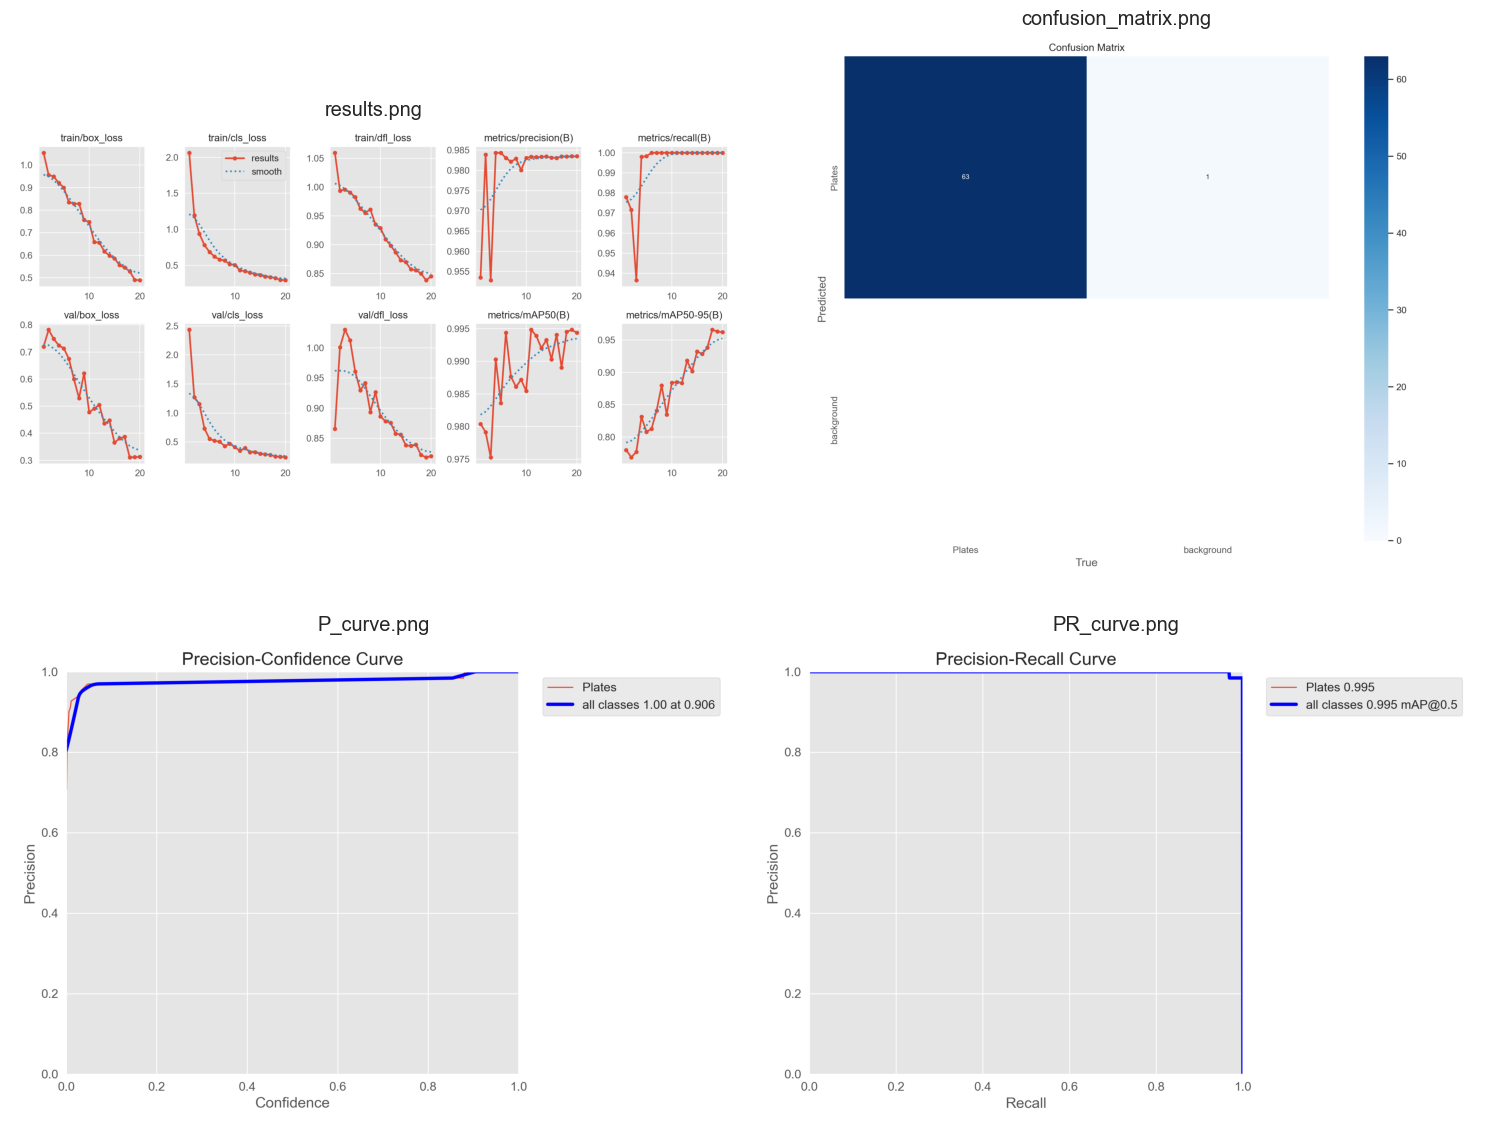

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Define the result path and the metrics
result_path = 'runs/detect/train'  # Ensure this is correct
metrics = ['results.png', 'confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

# Create a figure for plotting
plt.figure(figsize=(15, 12))
i = 1

# Iterate over each image and plot it
for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    
    # Check if the file exists
    if os.path.exists(image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        
        # Plot the image
        plt.subplot(2, 2, i)
        plt.imshow(image)
        plt.title(image_name)
        plt.axis('off')  # Hide the axis for better visualization
        i += 1
    else:
        print(f"File not found: {image_path}")


plt.tight_layout()  
plt.show()


In [24]:
# Read csv of result
df = pd.read_csv(os.path.join(result_path, 'results.csv'))
df.tail(5)

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16  258.113         0.55637         0.34281         0.85730   
16     17  272.360         0.54549         0.33541         0.85581   
17     18  287.069         0.52909         0.32248         0.85014   
18     19  301.208         0.49125         0.29789         0.83835   
19     20  315.822         0.48938         0.29162         0.84505   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.98307                1.0           0.99406   
16               0.98343                1.0           0.98906   
17               0.98346                1.0           0.99453   
18               0.98348                1.0           0.99484   
19               0.98349                1.0           0.99438   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.92854       0.38092       0.28746       0.83754  0.000515   
16              0.93825       0.38657       0.27832       0.83975  0.000416   
17              0.96602       0.31143       0.24936       0.82256  0.000317   
18              0.96324       0.31168       0.24280       0.81879  0.000218   
19              0.96219       0.31292       0.23676       0.82049  0.000119   

      lr/pg1    lr/pg2  
15  0.000515  0.000515  
16  0.000416  0.000416  
17  0.000317  0.000317  
18  0.000218  0.000218  
19  0.000119  0.000119

In [25]:
# Strip columns
df.columns = df.columns.str.strip()
df.columns

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

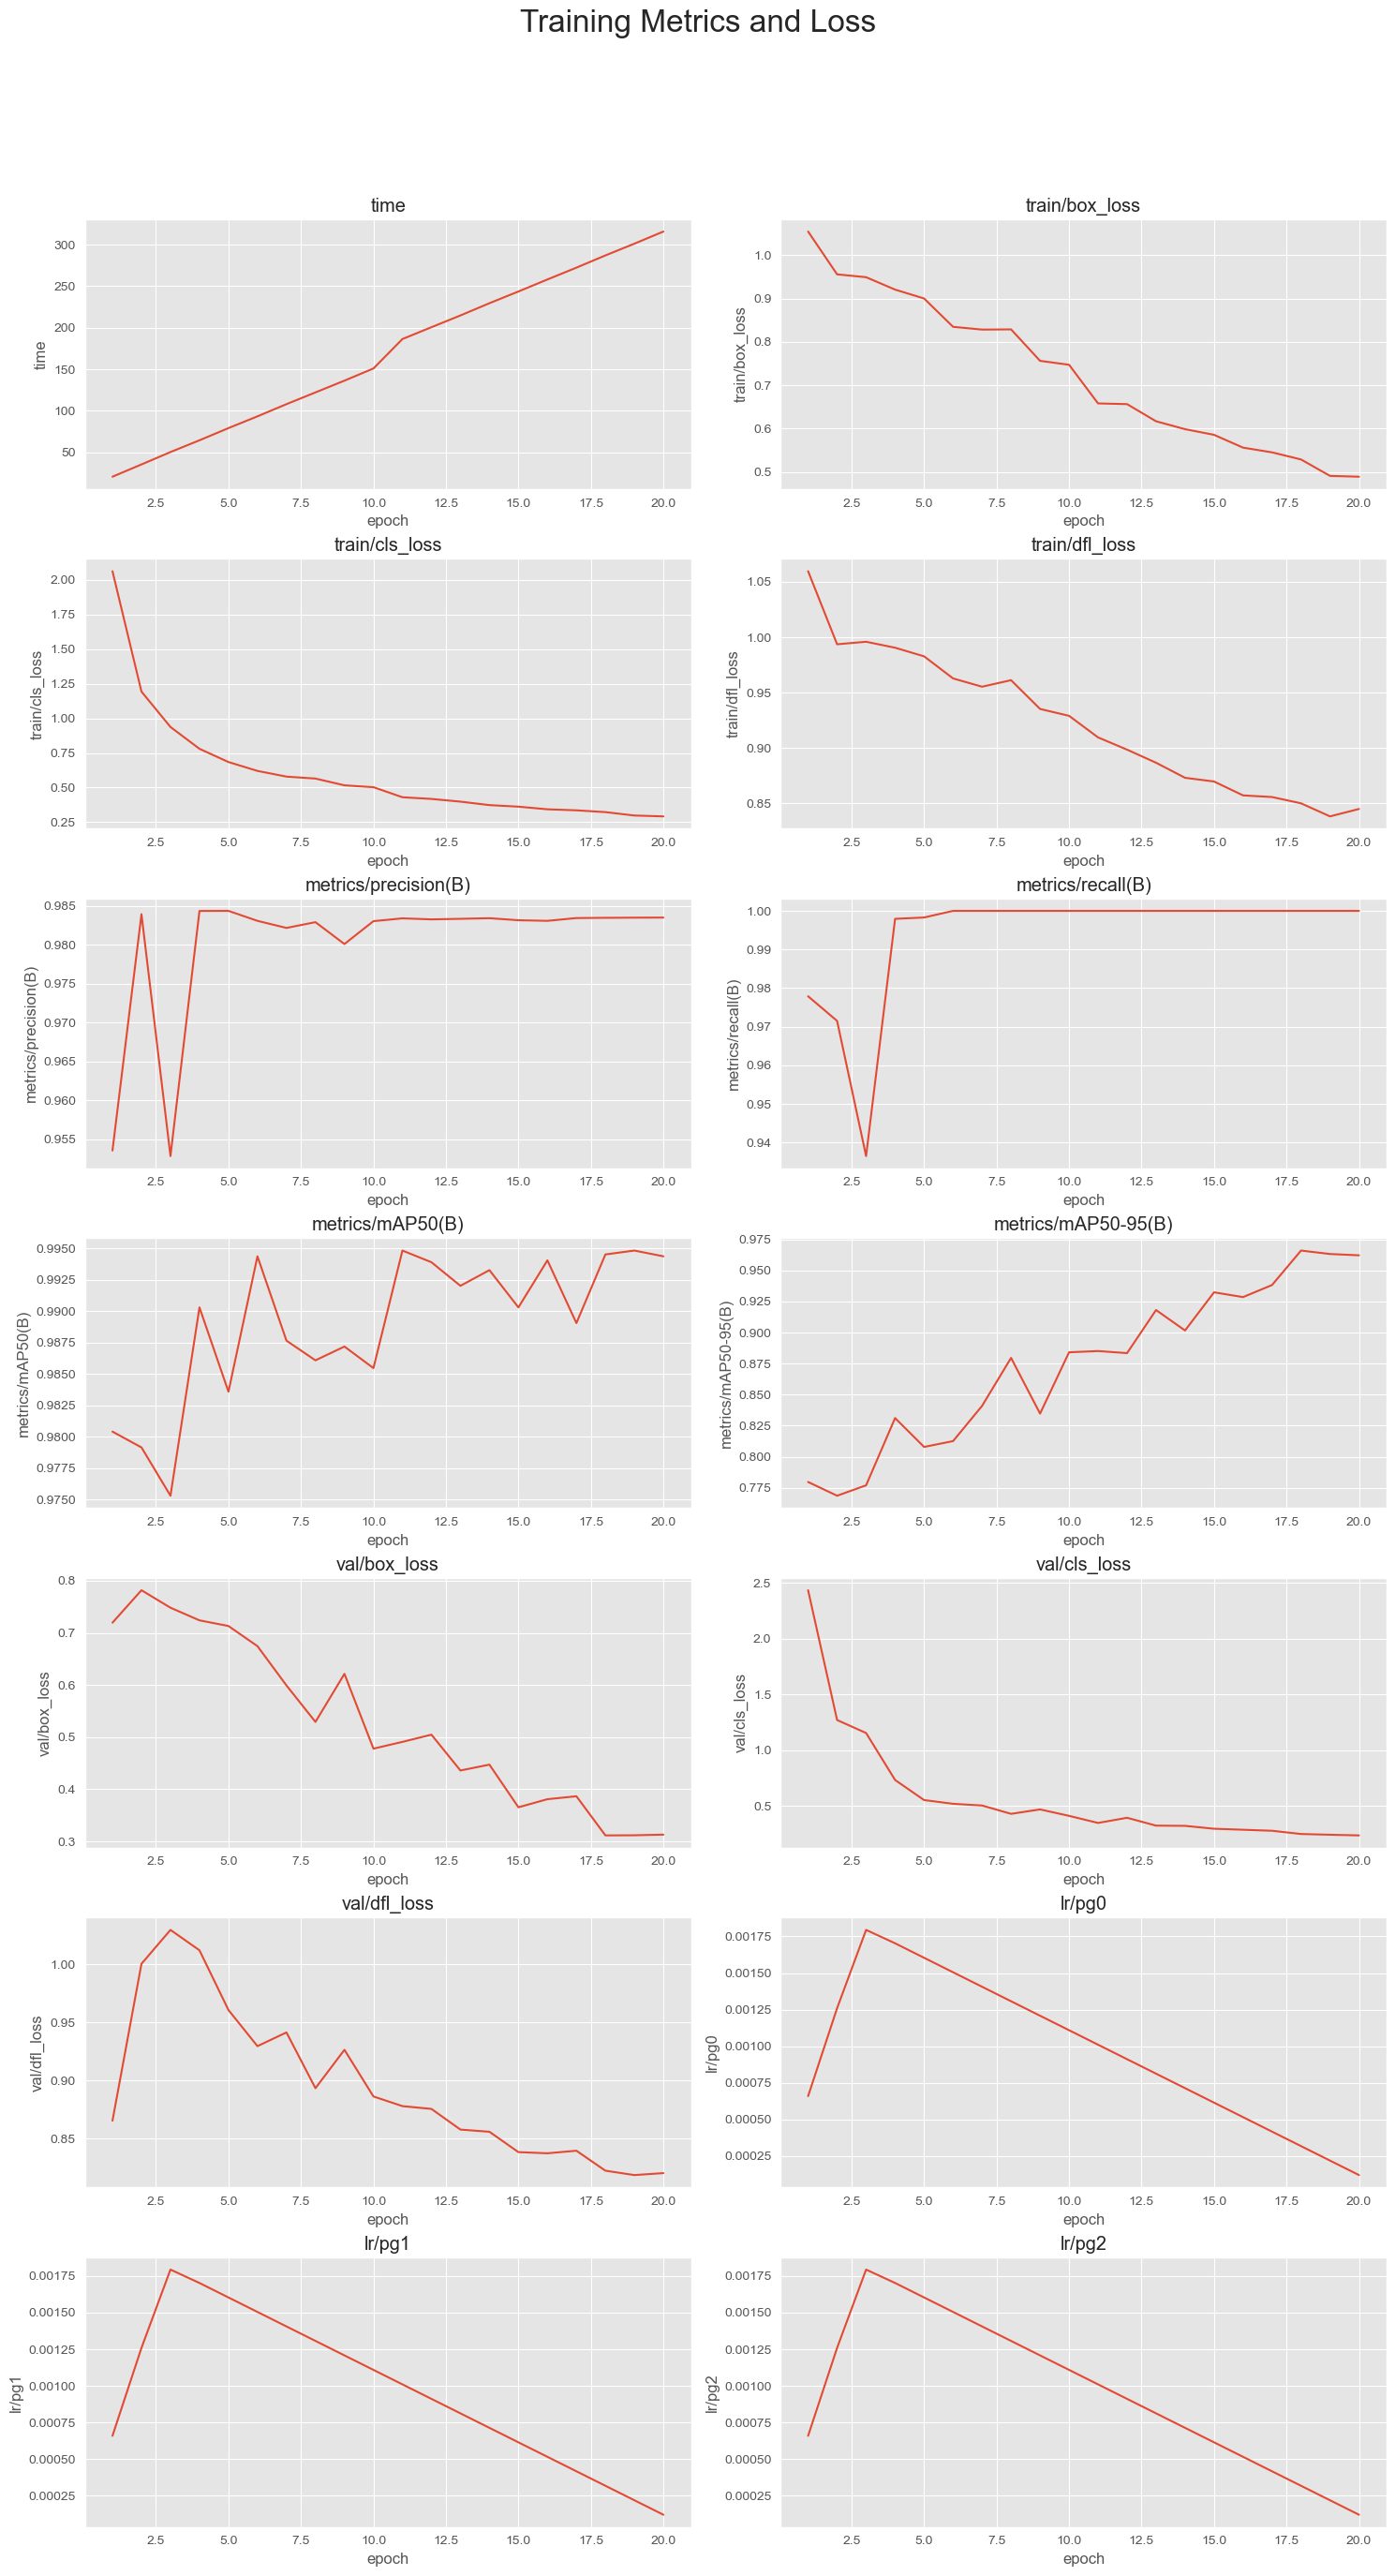

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y for plotting
X = df.epoch
cols = df.columns[1:]  # All columns except the first one (epoch)

# Calculate the number of rows and columns dynamically based on the number of metrics
num_metrics = len(cols)
num_rows = (num_metrics // 2) + (num_metrics % 2)

plt.figure(figsize=(15, num_rows * 4))  # Adjust figure height based on number of metrics

# Create subplots
for it in range(num_metrics):
    plt.subplot(num_rows, 2, it + 1)
    ax = sns.lineplot(data=df, x=X, y=cols[it])
    ax.set_title(cols[it])

# Add title and adjust layout
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top to give space for suptitle

plt.show()


In [27]:
from ultralytics import YOLO
import os

# Define the path to the best model weights
best_model_path = os.path.join(result_path, 'weights/best.pt')

# Check if the model file exists
if os.path.exists(best_model_path):
    print(f"Loading model from {best_model_path}")
    # Load the model with the best weights
    best_model_plate = YOLO(best_model_path)
else:
    print(f"Model not found at: {best_model_path}")

Loading model from runs/detect/train\weights/best.pt


In [28]:
from ultralytics import YOLO

# Load the best model (ensure best_model_path is correct)
best_model_path = os.path.join(result_path, 'weights/best.pt')
best_model_plate = YOLO(best_model_path)

# Evaluate the model
result_test = best_model_plate.val(data=plate_yaml_path)  # path to the data.yaml

print(result_test)


Ultralytics 8.3.64  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning E:\Machine Learning Project\Object detection with yolo\data\cars\valid\labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


                   all         63         63      0.983          1      0.995      0.966
Speed: 0.5ms preprocess, 6.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DEACD501A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03

In [29]:
print(result_test.results_dict)  # To check all keys and values

{'metrics/precision(B)': 0.9834590656738652, 'metrics/recall(B)': 1.0, 'metrics/mAP50(B)': 0.99453125, 'metrics/mAP50-95(B)': 0.9660196172502472, 'fitness': 0.9688707805252226}


In [30]:
# List of metrics
keys = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)']

for key in keys:
    if key in result_test.results_dict:
        print(colored(f'{key} : {result_test.results_dict[key]}', 'green', attrs=['bold']))
    else:
        print(colored(f'{key} not found in results', 'red', attrs=['bold']))


metrics/precision(B) : 0.9834590656738652
metrics/recall(B) : 1.0
metrics/mAP50(B) : 0.99453125


In [32]:
import random
import os

# Path of test images
plate_test_images = r'E:\Machine Learning Project\Object detection with yolo\data\cars\test\images'  # Make sure to update with the actual path

# All test images
images = os.listdir(plate_test_images)

# K - number of random images
num_samples = 12
random_images = random.choices(images, k=num_samples)

# Create a list of random image paths
image_paths = []
for image in random_images:
    image_path = os.path.join(plate_test_images, image)
    image_paths.append(image_path)

# Display the list of image paths
print(image_paths)


['E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\462_png.rf.fa1cd3857e332d063a51cb0d874375d8.jpg', 'E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\440_png.rf.36d7c55e758f4a7e4508e089468194c8.jpg', 'E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\353_png.rf.22f4f0bd6dd2077414cfd1731684361b.jpg', 'E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\301_png.rf.a1296bd5eb2c58a7891eb200c17e4274.jpg', 'E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\366_png.rf.a5d01241f01167706bb561f0f3564f5f.jpg', 'E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\350_png.rf.f6a23bdf59bdc6f9d04a09b5296ad98d.jpg', 'E:\\Machine Learning Project\\Object detection with yolo\\data\\cars\\test\\images\\450_png.rf.a02ede2455ccdfbe983666031cdd1b8d.jpg', 'E:\\Machine Learning Project\\Object detection with y

In [34]:
for image in images:
    image_path = os.path.join(plate_test_images, image)
    if os.path.exists(image_path):
        print(f"Found: {image_path}")
    else:
        print(f"Not found: {image_path}")


Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\192_png.rf.3acead9fe79797208877bfbeec07cc26.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\206_png.rf.ed4556ec5eeca1d2f5c82705324285e0.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\209_png.rf.6ebccd08d01c3950fa1fec916fe18a88.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\211_png.rf.3649bb1d1966dbc3cab6288ff17837a0.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\235_png.rf.b15a717d02bf70e4dcfc467b582751b6.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\250_png.rf.5a524c9c26d597a867a74258dd957f2f.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\280_png.rf.80aed7b81ae217f30e00d63972764ac7.jpg
Found: E:\Machine Learning Project\Object detection with yolo\data\cars\test

In [42]:
for image in images:
    image_path = os.path.join(plate_test_images, image)
    
    if os.path.exists(image_path):  
       
        result = best_model_plate.predict([image_path], save=True, conf=0.5, iou=0.7)
        
       
        boxes = result[0].boxes  
        if boxes is not None:
            print(f"Predicted for {image_path}: {boxes.xywh}")  
        else:
            print(f"No boxes detected for {image_path}.")
    else:
        print(f"Warning: Image {image_path} does not exist!")



0: 640x640 1 Plates, 31.3ms
Speed: 11.0ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Predicted for E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\192_png.rf.3acead9fe79797208877bfbeec07cc26.jpg: tensor([[547.5851, 499.9125, 419.2456, 186.2827]], device='cuda:0')

0: 640x640 1 Plates, 29.3ms
Speed: 11.2ms preprocess, 29.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Predicted for E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\206_png.rf.ed4556ec5eeca1d2f5c82705324285e0.jpg: tensor([[599.7409, 427.4359, 283.7984, 113.8900]], device='cuda:0')

0: 640x640 1 Plates, 41.5ms
Speed: 0.0ms preprocess, 41.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Predicted for E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\20

In [43]:
for image in images:
    image_path = os.path.join(plate_test_images, image)
    print(f"Checking path: {image_path}")
    if os.path.exists(image_path):
        print(f"Image {image_path} found!")
    else:
        print(f"Warning: Image {image_path} does not exist!")


Checking path: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\192_png.rf.3acead9fe79797208877bfbeec07cc26.jpg
Image E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\192_png.rf.3acead9fe79797208877bfbeec07cc26.jpg found!
Checking path: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\206_png.rf.ed4556ec5eeca1d2f5c82705324285e0.jpg
Image E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\206_png.rf.ed4556ec5eeca1d2f5c82705324285e0.jpg found!
Checking path: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\209_png.rf.6ebccd08d01c3950fa1fec916fe18a88.jpg
Image E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\209_png.rf.6ebccd08d01c3950fa1fec916fe18a88.jpg found!
Checking path: E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\211_png.rf.3649bb1d1966dbc3cab6288ff17837a0.jpg
Image E:\Machine Learning 

In [45]:
# Extract the bounding box coordinates (x_center, y_center, width, height)
for image in images:
    image_path = os.path.join(plate_test_images, image)
    
    if os.path.exists(image_path):  
        
        result = best_model_plate.predict([image_path], save=True, conf=0.5, iou=0.7)
        
        
        boxes = result[0].boxes 
        if boxes is not None:
            for box in boxes.xywh:
                x_center, y_center, width, height = box
                
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                
                print(f"Predicted bounding box for {image_path}: (x1, y1) = ({x1}, {y1}), (x2, y2) = ({x2}, {y2})")
        else:
            print(f"No boxes detected for {image_path}.")
    else:
        print(f"Warning: Image {image_path} does not exist!")



0: 640x640 1 Plates, 31.3ms
Speed: 6.9ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Predicted bounding box for E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\192_png.rf.3acead9fe79797208877bfbeec07cc26.jpg: (x1, y1) = (337.96234130859375, 406.7711181640625), (x2, y2) = (757.2079467773438, 593.0538330078125)

0: 640x640 1 Plates, 128.1ms
Speed: 4.7ms preprocess, 128.1ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Predicted bounding box for E:\Machine Learning Project\Object detection with yolo\data\cars\test\images\206_png.rf.ed4556ec5eeca1d2f5c82705324285e0.jpg: (x1, y1) = (457.84173583984375, 370.49090576171875), (x2, y2) = (741.6400756835938, 484.38092041015625)

0: 640x640 1 Plates, 86.3ms
Speed: 4.6ms preprocess, 86.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\pred

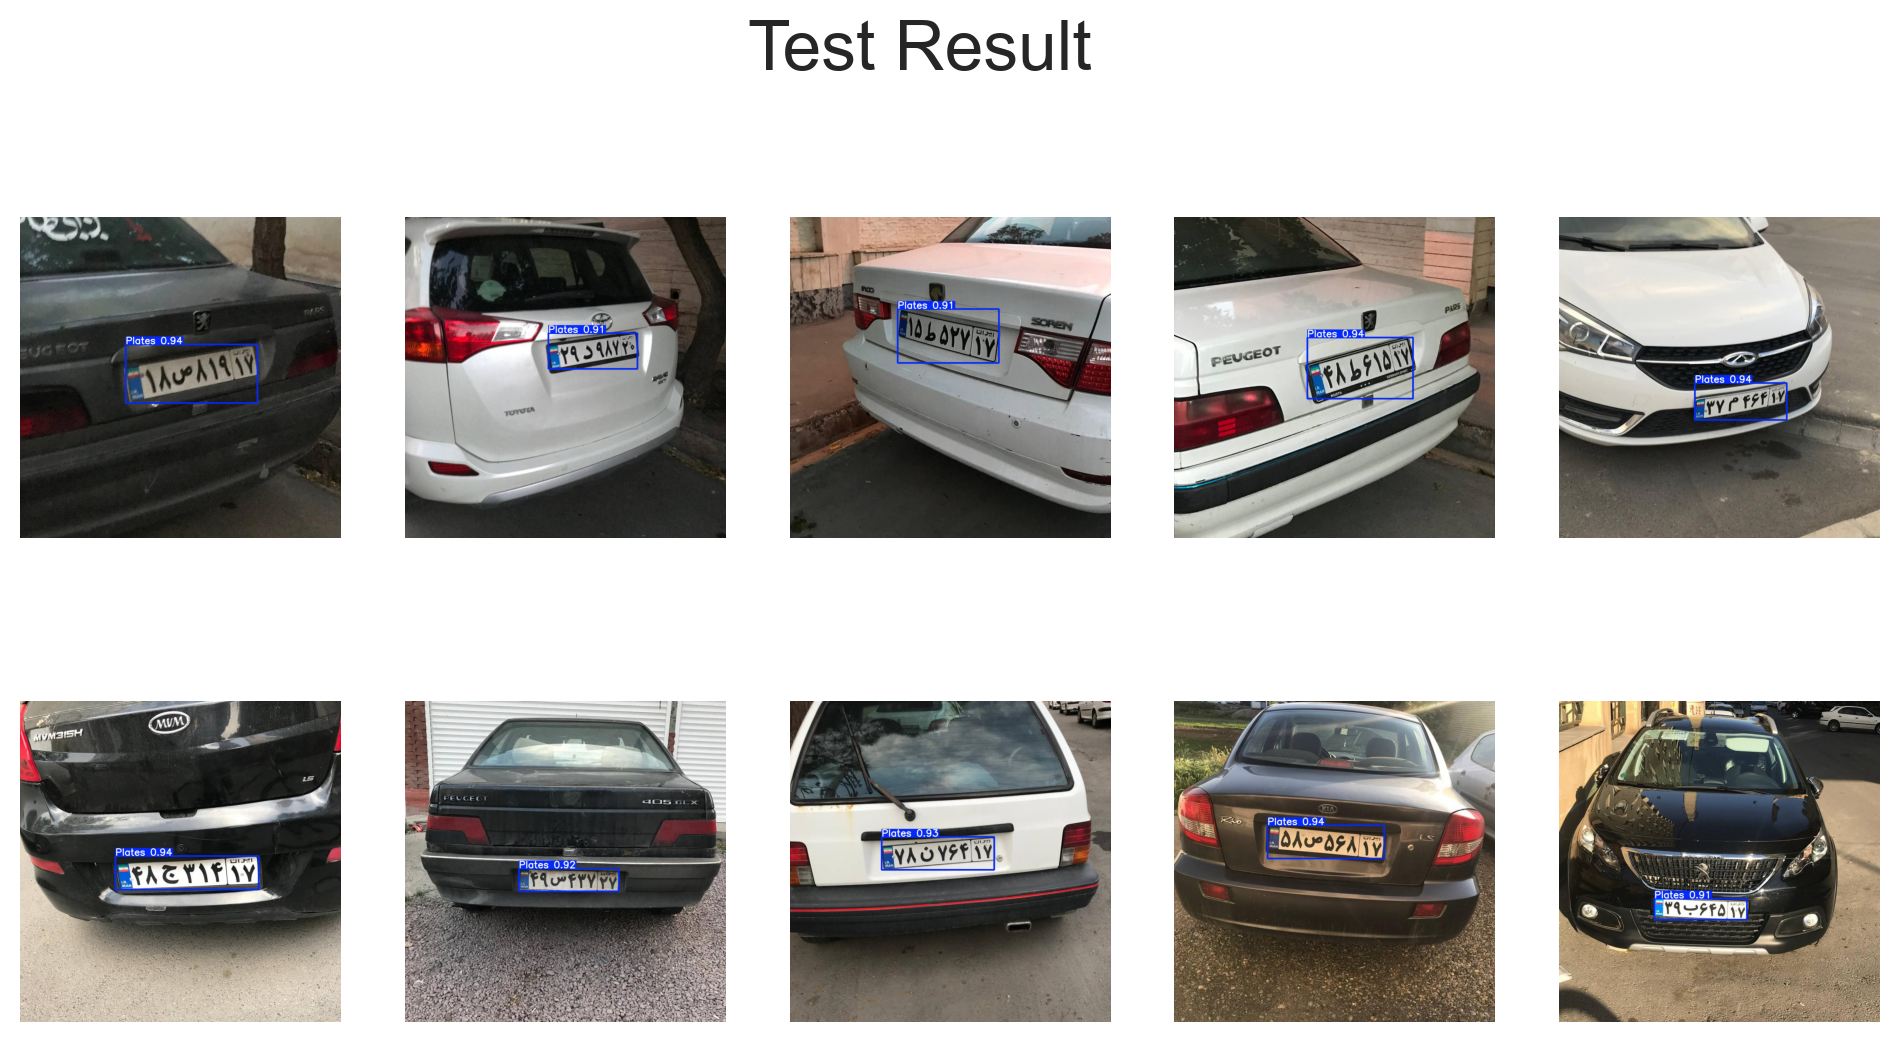

In [ ]:
import matplotlib.pyplot as plt
import os

# Define result path
result_path = r'runs\detect\predict'  

# Show images
plt.figure(figsize=(12, 6), dpi=200)
plt.suptitle('Test Result', fontsize=25, fontweight=500)  

i = 1
for image in os.listdir(result_path):
    image_path = os.path.join(result_path, image)
    
    # Plot the image
    plt.subplot(2, 5, i)
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    
    # Adjust layout for better visualization
    plt.subplots_adjust(top=0.85)
    
    i += 1
    if i > 10:  
        break

plt.show()
